In [1]:
import wandb
wandb.login()
import os
os.environ['WANDB_PROJECT'] = 'shortest_v3_model'
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import csrgraph as cg
import numpy as np
import random
import string
from itertools import combinations
import pickle
import gc
import os
import json
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm


#os.environ['WANDB_MODE'] = 'disabled'

# set current directory
os.chdir("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS")

wandb: Currently logged in as: carobgt (carobgt-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
import os
import shutil
import random
import networkx as nx
import numpy as np
import string
from tqdm import tqdm

# --- 1. UTILITY FUNCTIONS ---

def get_graph_with_random_names(size):
    """Creates a grid graph with unique random 2-letter names."""
    num_nodes = size * size
    names = set()
    while len(names) < num_nodes:
        names.add(''.join(random.choices(string.ascii_lowercase, k=2)))
    
    nodes = list(names)
    random.shuffle(nodes) # Important for breaking name predictability
    
    G = nx.DiGraph()
    for r in range(size):
        for c in range(size):
            idx = r * size + c
            u = nodes[idx]
            if c < size - 1: G.add_edge(u, nodes[idx + 1], direction='EAST')
            if c > 0: G.add_edge(u, nodes[idx - 1], direction='WEST')
            if r < size - 1: G.add_edge(u, nodes[idx + size], direction='SOUTH')
            if r > 0: G.add_edge(u, nodes[idx - size], direction='NORTH')
    return G

def generate_random_walk(G, start_node, length):
    """Generates a simple random walk allowing backtracking."""
    path = [start_node]
    current_node = start_node
    while len(path) < length:
        neighbors = list(G.successors(current_node))
        if not neighbors: break
        next_node = random.choice(neighbors)
        path.append(next_node)
        current_node = next_node
    return path

def format_path_to_string(path, G):
    """Converts a list of nodes into a 'NODE DIR NODE...' string."""
    if not path or len(path) < 2: return path[0] if path else ""
    path_str = ""
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        try:
            direction = G.edges[u, v]['direction']
            path_str += f"{u} {direction} "
        except KeyError:
            # Safety check, although this should not be triggered with valid paths
            print(f"Warning: Edge ({u}, {v}) not found in graph. Skipping segment.")
            continue
    path_str += path[-1]
    return path_str

# --- 2. CORE LOGIC for "Persistent Filtering" ---

def generate_geometer_example(grid_size, min_walk_len, max_walk_len, max_walk_attempts=100000):
    """
    Generates a single example for the Geometer model using the
    "Persistent Filtering" method, correctly handling multiple shortest paths.
    """
    # 1. Unbiased Task Selection: Pick the task FIRST.
    G = get_graph_with_random_names(grid_size)
    nodes = list(G.nodes())
    start_node, goal_node = random.sample(nodes, 2)
    
    try:
        # 2. Find ALL shortest paths and their required node sets.
        all_solution_paths = list(nx.all_shortest_paths(G, source=start_node, target=goal_node))
        if not all_solution_paths:
            return None
        
        # This is now a list of sets of nodes, one for each valid shortest path.
        list_of_required_nodes = [set(p) for p in all_solution_paths]
        
    except (nx.NetworkXNoPath, StopIteration):
        return None # Should not happen on a connected grid

    # 3. Inner Loop: Brute-force a valid context.
    for _ in range(max_walk_attempts):
        walk_len = random.randint(min_walk_len, max_walk_len)
        walk_start_node = random.choice(nodes)
        context_walk = generate_random_walk(G, walk_start_node, walk_len)
        
        nodes_in_walk = set(context_walk)
        
        # 4. Find which shortest paths are actually supported by this context
        supported_paths = []
        for i, req_nodes in enumerate(list_of_required_nodes):
            if req_nodes.issubset(nodes_in_walk):
                supported_paths.append(all_solution_paths[i])
        
        # 5. Check if at least one path is supported
        if supported_paths:
            # 6. Success! Pick a target from only the supported paths
            ground_truth_path = random.choice(supported_paths)
            
            context_str = format_path_to_string(context_walk, G)
            target_str = format_path_to_string(ground_truth_path, G)
            
            task_instruction = f"[SHORTEST] [START_NODE] {start_node} [GOAL] {goal_node}"
            prompt = f"[SOS] {context_str} [SEP] {task_instruction} [PLAN]"
            target = f"{target_str} [EOS]"
            
            return prompt, target
    
    # If the inner loop finishes without finding a context, we failed for this task.
    # Returning None signals to the main loop to try a new, different task.
    return None


def generate_and_save_dataset(n_examples, grid_size, min_walk_len, max_walk_len, output_file_path, description=""):
    """Orchestrates generating and saving the full dataset."""
    print(f"--- Generating {n_examples} examples for {description} ---")
    
    with open(output_file_path, "w", encoding="utf-8") as f:
        pbar = tqdm(total=n_examples, desc=f"Generating {description}")
        generated_count = 0
        attempts = 0
        max_total_attempts = n_examples * 1000  # Prevent infinite loops
        
        while generated_count < n_examples and attempts < max_total_attempts:
            attempts += 1
            example = generate_geometer_example(grid_size, min_walk_len, max_walk_len)
            
            if example:
                prompt, target = example
                f.write(f"{prompt} {target}\n")
                generated_count += 1
                pbar.update(1)
        
        pbar.close()
        
        if attempts >= max_total_attempts:
            print(f"Warning: Hit maximum attempts ({max_total_attempts}). Generated {generated_count}/{n_examples} examples.")
        else:
            success_rate = generated_count / attempts * 100
            print(f"Success rate: {success_rate:.2f}% ({generated_count}/{attempts} attempts)")

In [25]:

# --- 3. MAIN EXECUTION BLOCK ---

if __name__ == "__main__":
    # --- Configuration ---
    NUM_TRAIN_EXAMPLES = 1000000
    NUM_TEST_EXAMPLES = 10000
    GRID_SIZE = 4
    
    # Walk lengths should be generous to increase the chance of node coverage for
    # the persistent filtering method to be efficient.
    MIN_WALK_LENGTH = 10
    MAX_WALK_LENGTH = 50

    # Set a seed for reproducibility of the entire script
    random.seed(42)
    np.random.seed(42)

    # --- Setup Output Directory ---
    output_dir = "sv3_data"
    if os.path.exists(output_dir):
        print(f"Removing existing directory: {output_dir}")
        shutil.rmtree(output_dir)
    print(f"Creating new directory: {output_dir}")
    os.makedirs(output_dir)

    # --- Generate Training Data ---
    train_file_path = os.path.join(output_dir, "train.txt")
    generate_and_save_dataset(
        n_examples=NUM_TRAIN_EXAMPLES,
        grid_size=GRID_SIZE,
        min_walk_len=MIN_WALK_LENGTH,
        max_walk_len=MAX_WALK_LENGTH,
        output_file_path=train_file_path,
        description="Training Set"
    )

    # --- Generate Testing Data ---
    test_file_path = os.path.join(output_dir, "test.txt")
    generate_and_save_dataset(
        n_examples=NUM_TEST_EXAMPLES,
        grid_size=GRID_SIZE,
        min_walk_len=MIN_WALK_LENGTH,
        max_walk_len=MAX_WALK_LENGTH,
        output_file_path=test_file_path,
        description="Testing Set"
    )

    print(f"\n--- SV3 data generation using 'Persistent Filtering' finished successfully! ---")



Removing existing directory: sv3_data
Creating new directory: sv3_data
--- Generating 1000000 examples for Training Set ---


Generating Training Set:   0%|          | 0/1000000 [00:00<?, ?it/s]

Generating Training Set: 100%|██████████| 1000000/1000000 [01:45<00:00, 9505.75it/s]


Success rate: 100.00% (1000000/1000000 attempts)
--- Generating 10000 examples for Testing Set ---


Generating Testing Set: 100%|██████████| 10000/10000 [00:01<00:00, 9579.47it/s]

Success rate: 100.00% (10000/10000 attempts)

--- SV3 data generation using 'Persistent Filtering' finished successfully! ---


In [27]:
# Analysis tools
from transformers import GPT2Tokenizer
import numpy as np
def analyse_dataset(file_path, tokenizer_path):
    """
    Analyze context/target ratio in existing dataset.
    """
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    
    total_context_tokens = 0
    total_target_tokens = 0
    ratios = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= 1000:  # Analyze first 1000 examples
                break
                
            parts = line.strip().split()
            sep_index = parts.index('[PLAN]')
            prompt = ' '.join(parts[:sep_index])
            target = ' '.join(parts[sep_index + 1:])

            
            # Extract context (before [SEP])
            if '[SEP]' in prompt:
                context_part = prompt.split('[SEP]')[0]
            else:
                context_part = prompt
            
            context_tokens = len(tokenizer.encode(context_part))
            target_tokens = len(tokenizer.encode(target))
            
            if target_tokens > 0:
                ratio = context_tokens / target_tokens
                ratios.append(ratio)
                total_context_tokens += context_tokens
                total_target_tokens += target_tokens
    
    if ratios:
        avg_ratio = total_context_tokens / total_target_tokens
        median_ratio = np.median(ratios)
        
        print(f"Dataset Analysis ({len(ratios)} examples):")
        print(f"Average context/target ratio: {avg_ratio:.2f}")
        print(f"Median ratio: {median_ratio:.2f}")
        print(f"Ratio range: {min(ratios):.2f} - {max(ratios):.2f}")
        
        if avg_ratio > 3.0:
            print("Context heavily dominates - consider shorter contexts")
        elif avg_ratio < 0.5:
            print("Target dominates - consider longer contexts") 
        else:
            print("Reasonable balance")

analyse_dataset("sv3_data/train.txt", "gv6_tokenizer")

Dataset Analysis (1000 examples):
Average context/target ratio: 8.82
Median ratio: 9.00
Ratio range: 1.88 - 21.43
Context heavily dominates - consider shorter contexts


**CUSTOM TOKENIZER**

trained in tokenizer_training.ipynb


In [2]:
class GPT:

    def __init__(self, base_model=None, base_model_name='gpt2', vocab_size=100):
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.vocab_size = vocab_size

        if self.base_model is not None:
            self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
            self.model = GPT2LMHeadModel.from_pretrained(base_model)
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def continue_input(self, input_sequence, max_new_tokens=5, num_return_sequences=1, no_repeat_ngram_size=0,
                       do_sample=False, temperature=0.7, num_beams=1):
        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt')

        # Generate text
        output = self.model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
            temperature=temperature,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text
    
    

In [3]:
def load_pkl(pth):
    with open(pth, 'rb') as f:
        d = pickle.load(f)
    return d

def is_valid_path(sequence, graphs):
    # Split the sequence into parts
    parts = sequence.split()

    # Extract nodes and edges; nodes are at even indices, edges at odd indices
    nodes = parts[::2]
    edges = parts[1::2]

    # Convert edges to a lowercase version for comparison (assuming all edges in graphs are lowercase)
    edges = [edge.lower() for edge in edges]

    # Iterate over each graph to check if the path exists
    for graph in graphs:
        path_exists = True
        for i in range(len(nodes) - 1):
            # Check if the current graph has the edge between the current node and the next node
            if not graph.has_edge(nodes[i], nodes[i+1]):
                path_exists = False
                break

        # If path exists in the current graph, return True
        if path_exists:
            return True

    # If none of the graphs contain the path, return False
    return False

In [30]:
from transformers import AutoConfig, GPT2Tokenizer
import os

# --- Configuration ---
TOKENIZER_PATH = "gv6_tokenizer"
# Give it a descriptive name to remember what's in it
CONFIG_SAVE_PATH = "shortest_v3_config_pdrop" 

# 1. Load the custom tokenizer
print(f"Loading custom tokenizer from: {TOKENIZER_PATH}")
my_custom_tokenizer = GPT2Tokenizer.from_pretrained(TOKENIZER_PATH)

# 2. Load the base gpt2 config as a blueprint
print("Loading base gpt2 config...")
config = AutoConfig.from_pretrained('gpt2')

# 3. Override tokenizer properties
print(f"Overriding config vocab_size. Old: {config.vocab_size}, New: {len(my_custom_tokenizer)}")
config.vocab_size = len(my_custom_tokenizer)
config.bos_token_id = my_custom_tokenizer.bos_token_id
config.eos_token_id = my_custom_tokenizer.eos_token_id
config.pad_token_id = my_custom_tokenizer.pad_token_id
print(f"Set pad_token_id to: {config.pad_token_id}")

# --- ACTION: ADD DROPOUT MODIFICATION HERE ---
new_dropout_rate = 0.5
print(f"Setting all dropout probabilities to: {new_dropout_rate}")
config.attn_pdrop = new_dropout_rate
config.resid_pdrop = new_dropout_rate
config.embd_pdrop = new_dropout_rate
# ---------------------------------------------

# 4. Save the new, modified config to its own directory
os.makedirs(CONFIG_SAVE_PATH, exist_ok=True)
config.save_pretrained(CONFIG_SAVE_PATH)

print(f"\nCustom model config with high dropout saved successfully to: {CONFIG_SAVE_PATH}")

Loading custom tokenizer from: gv6_tokenizer
Loading base gpt2 config...
Overriding config vocab_size. Old: 50257, New: 1031
Set pad_token_id to: 0
Setting all dropout probabilities to: 0.5

Custom model config with high dropout saved successfully to: shortest_v3_config_pdrop


In [4]:
import os

# Define the path for new cache directory 
project_cache_path = os.path.join(os.getcwd(), '.cache', 'huggingface_datasets')
os.makedirs(project_cache_path, exist_ok=True)

# Set the environment variable to tell the 'datasets' library to use this new path
os.environ['HF_DATASETS_CACHE'] = project_cache_path

print(f"Hugging Face datasets cache is now set to: {os.environ['HF_DATASETS_CACHE']}")

wandb_path = os.path.join(os.getcwd(), 'wandb_local_runs')
os.makedirs(wandb_path, exist_ok=True)
# Set the environment variable to tell 'wandb' to use this new path
os.environ['WANDB_DIR'] = wandb_path
print(f"Wandb local run directory set to: {os.environ['WANDB_DIR']}")

import os
os.environ["WANDB__SERVICE_WAIT"] = "120"

Hugging Face datasets cache is now set to: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/.cache/huggingface_datasets
Wandb local run directory set to: /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/wandb_local_runs


In [5]:
# run_training.py (or whatever you want to call your main script)

import os
import gc
import wandb

def train_model_script(num_epochs=1,
                       output_dir='sv3_model_ft', # Changed default name
                       lr=5e-05,
                       wandb_run_id=None):
    gc.collect()
    wandb.login()
    os.environ['WANDB_PROJECT'] = 'shortest_path_models'

    save_steps = 1000
    save_total_limit = 10
    weight_decay = 0.1
    beta2 = 0.98
    
    # --- Define Clean Paths ---
    data_dir = 'sv3_data' 
    tokenizer_dir = 'gv6_tokenizer'
    config_dir = 'shortest_v3_config_pdrop'
    
    train_path = f'./{data_dir}/train.txt'
    test_path = f'./{data_dir}/test.txt'
    if wandb_run_id:
        print(f"Attempting to resume W&B run with ID: {wandb_run_id}")
        os.environ['WANDB_RESUME'] = "allow"
        os.environ['WANDB_RUN_ID'] = wandb_run_id

    command = f"""
    python3 ./train_shortest.py \\
        --config_name {config_dir} \\
        --tokenizer_name {tokenizer_dir} \\
        --train_file {train_path} \\
        --validation_file {test_path} \\
        --per_device_train_batch_size 128 \\
        --per_device_eval_batch_size 128\\
        --do_train \\
        --do_eval \\
        --output_dir {output_dir} \\
        --num_train_epochs {num_epochs} \\
        --save_strategy 'steps' \\
        --save_steps {save_steps} \\
        --save_total_limit {save_total_limit} \\
        --eval_strategy 'steps' \\
        --eval_steps 500 \\
        --warmup_steps 0 \\
        --learning_rate {lr} \\
        --report_to 'wandb' \\
        --lr_scheduler_type cosine \\
        --weight_decay {weight_decay} \\
        --adam_beta2 {beta2} \\
        --fp16 True
    """
    
    print("--- Running Command ---")
    print(command)
    print("-----------------------")
    
    os.system(command)

In [ ]:
#!rm -rf sv2_model_fixed/
!mkdir sv3_model_ft/

mkdir: cannot create directory ‘sv3_model_unm/’: File exists


In [ ]:


train_model_script(num_epochs=25,
                   output_dir='sv3_model_ft',
                   lr=1e-05, wandb_run_id="9p43e26h")


Attempting to resume W&B run with ID: 9p43e26h
--- Running Command ---

    python3 ./train_shortest.py \
        --config_name shortest_v3_config_pdrop \
        --tokenizer_name gv6_tokenizer \
        --train_file ./sv3_data/train.txt \
        --validation_file ./sv3_data/test.txt \
        --per_device_train_batch_size 128 \
        --per_device_eval_batch_size 128\
        --do_train \
        --do_eval \
        --output_dir sv3_model_ft \
        --num_train_epochs 25 \
        --save_strategy 'steps' \
        --save_steps 1000 \
        --save_total_limit 10 \
        --eval_strategy 'steps' \
        --eval_steps 500 \
        --warmup_steps 0 \
        --learning_rate 1e-05 \
        --report_to 'wandb' \
        --lr_scheduler_type cosine \
        --weight_decay 0.1 \
        --adam_beta2 0.98 \
        --fp16 True
    
-----------------------


/cs/student/projects1/aibh/2024/cbaumgar/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


INFO:__main__:Checkpoint detected, resuming training at sv3_model_ft/checkpoint-123500. To avoid this behavior, change the `--output_dir` or add `--overwrite_output_dir` to train from scratch.
INFO:__main__:Loading tokenizer, config, and model...
INFO:__main__:--- Initializing a new model from scratch ---
INFO:__main__:Synchronized model embedding size with tokenizer. New size: 1031


/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/./train_shortest.py:228: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


INFO:__main__:*** Starting Training ***


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
	save_steps: 1000 (from args) != 500 (from trainer_state.json)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: carobgt (carobgt-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: creating run
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/wandb_local_runs/wandb/run-20250821_142629-9p43e26h
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run sv3_model_ft
wandb: ⭐️ View project at https://wandb.ai/carobgt-ucl/shortest_path_models
wandb: 🚀 View run at https://wandb.ai/carobgt-ucl/shortest_path_models/runs/9p43e26h
 63%|██████▎   | 124000/195325 [06:04<8:34:21,  2.31it/s] 

{'loss': 0.0889, 'grad_norm': 1.0165162086486816, 'learning_rate': 2.9482476497660644e-05, 'epoch': 15.87}



 99%|█████████▊| 78/79 [00:12<00:00,  6.17it/s]
                                                         
 63%|██████▎   | 124000/195325 [06:17<8:34:21,  2.31it/s]
                                               

{'eval_loss': 0.1009625494480133, 'eval_token_accuracy': 0.9573899155829341, 'eval_exact_match_accuracy': 0.6261, 'eval_runtime': 13.273, 'eval_samples_per_second': 753.411, 'eval_steps_per_second': 5.952, 'epoch': 15.87}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0896, 'grad_norm': 1.3696781396865845, 'learning_rate': 2.9117190108813792e-05, 'epoch': 15.93}



 97%|█████████▋| 77/79 [00:11<00:00,  6.49it/s]
                                                         
100%|██████████| 79/79 [00:28<00:00,  6.57it/s]
                                               

{'eval_loss': 0.10647807270288467, 'eval_token_accuracy': 0.9566324435318275, 'eval_exact_match_accuracy': 0.6202, 'eval_runtime': 28.8881, 'eval_samples_per_second': 346.163, 'eval_steps_per_second': 2.735, 'epoch': 15.93}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0909, 'grad_norm': 0.9367993474006653, 'learning_rate': 2.8752520898363257e-05, 'epoch': 16.0}



 97%|█████████▋| 77/79 [00:11<00:00,  6.50it/s]
                                                         
100%|██████████| 79/79 [00:20<00:00,  6.57it/s]
                                               

{'eval_loss': 0.11856304854154587, 'eval_token_accuracy': 0.9553912845083277, 'eval_exact_match_accuracy': 0.6172, 'eval_runtime': 20.7694, 'eval_samples_per_second': 481.478, 'eval_steps_per_second': 3.804, 'epoch': 16.0}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0896, 'grad_norm': 1.124891757965088, 'learning_rate': 2.838922582214314e-05, 'epoch': 16.06}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                         
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10282918810844421, 'eval_token_accuracy': 0.9572986538900297, 'eval_exact_match_accuracy': 0.624, 'eval_runtime': 12.4456, 'eval_samples_per_second': 803.496, 'eval_steps_per_second': 6.348, 'epoch': 16.06}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0901, 'grad_norm': 1.406823754310608, 'learning_rate': 2.8027328375467722e-05, 'epoch': 16.13}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                         
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10580505430698395, 'eval_token_accuracy': 0.9567419575633128, 'eval_exact_match_accuracy': 0.618, 'eval_runtime': 12.55, 'eval_samples_per_second': 796.815, 'eval_steps_per_second': 6.295, 'epoch': 16.13}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0901, 'grad_norm': 1.3215935230255127, 'learning_rate': 2.7666851963262717e-05, 'epoch': 16.19}



 97%|█████████▋| 77/79 [00:11<00:00,  6.46it/s]
                                                         
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.09518380463123322, 'eval_token_accuracy': 0.9580287474332649, 'eval_exact_match_accuracy': 0.6286, 'eval_runtime': 12.4231, 'eval_samples_per_second': 804.951, 'eval_steps_per_second': 6.359, 'epoch': 16.19}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0897, 'grad_norm': 0.9879333972930908, 'learning_rate': 2.7307819898551485e-05, 'epoch': 16.25}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                         
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10404183715581894, 'eval_token_accuracy': 0.9571161305042208, 'eval_exact_match_accuracy': 0.6259, 'eval_runtime': 12.3983, 'eval_samples_per_second': 806.559, 'eval_steps_per_second': 6.372, 'epoch': 16.25}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0891, 'grad_norm': 1.3298487663269043, 'learning_rate': 2.695025540094741e-05, 'epoch': 16.32}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                         
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10515214502811432, 'eval_token_accuracy': 0.9569062286105408, 'eval_exact_match_accuracy': 0.6225, 'eval_runtime': 12.4189, 'eval_samples_per_second': 805.224, 'eval_steps_per_second': 6.361, 'epoch': 16.32}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0889, 'grad_norm': 1.2815712690353394, 'learning_rate': 2.659418159515221e-05, 'epoch': 16.38}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                         
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10559582710266113, 'eval_token_accuracy': 0.9567145790554414, 'eval_exact_match_accuracy': 0.6217, 'eval_runtime': 12.3902, 'eval_samples_per_second': 807.091, 'eval_steps_per_second': 6.376, 'epoch': 16.38}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0886, 'grad_norm': 0.7125038504600525, 'learning_rate': 2.6239621509460312e-05, 'epoch': 16.45}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                         
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10004551708698273, 'eval_token_accuracy': 0.9568332192562172, 'eval_exact_match_accuracy': 0.6222, 'eval_runtime': 12.5486, 'eval_samples_per_second': 796.905, 'eval_steps_per_second': 6.296, 'epoch': 16.45}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.088, 'grad_norm': 1.0778522491455078, 'learning_rate': 2.5886598074269595e-05, 'epoch': 16.51}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                         
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.1023077666759491, 'eval_token_accuracy': 0.9572986538900297, 'eval_exact_match_accuracy': 0.626, 'eval_runtime': 12.428, 'eval_samples_per_second': 804.636, 'eval_steps_per_second': 6.357, 'epoch': 16.51}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0884, 'grad_norm': 1.437631368637085, 'learning_rate': 2.5535134120598503e-05, 'epoch': 16.57}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                         
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10544010996818542, 'eval_token_accuracy': 0.9569974903034452, 'eval_exact_match_accuracy': 0.6242, 'eval_runtime': 12.4274, 'eval_samples_per_second': 804.674, 'eval_steps_per_second': 6.357, 'epoch': 16.57}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0869, 'grad_norm': 1.498881220817566, 'learning_rate': 2.5185252378609392e-05, 'epoch': 16.64}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10262873768806458, 'eval_token_accuracy': 0.9567784622404746, 'eval_exact_match_accuracy': 0.6246, 'eval_runtime': 12.445, 'eval_samples_per_second': 803.533, 'eval_steps_per_second': 6.348, 'epoch': 16.64}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.087, 'grad_norm': 1.5458972454071045, 'learning_rate': 2.483767041332517e-05, 'epoch': 16.7}



 97%|█████████▋| 77/79 [00:11<00:00,  6.46it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.53it/s]
                                               

{'eval_loss': 0.09773968160152435, 'eval_token_accuracy': 0.9580378736025553, 'eval_exact_match_accuracy': 0.6291, 'eval_runtime': 12.4484, 'eval_samples_per_second': 803.314, 'eval_steps_per_second': 6.346, 'epoch': 16.7}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0875, 'grad_norm': 1.0886317491531372, 'learning_rate': 2.449170926393212e-05, 'epoch': 16.77}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10607296228408813, 'eval_token_accuracy': 0.9565959388546658, 'eval_exact_match_accuracy': 0.6248, 'eval_runtime': 12.4879, 'eval_samples_per_second': 800.774, 'eval_steps_per_second': 6.326, 'epoch': 16.77}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0871, 'grad_norm': 1.2698718309402466, 'learning_rate': 2.414670286374509e-05, 'epoch': 16.83}



 97%|█████████▋| 77/79 [00:11<00:00,  6.46it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10783631354570389, 'eval_token_accuracy': 0.9575450604608715, 'eval_exact_match_accuracy': 0.6271, 'eval_runtime': 12.389, 'eval_samples_per_second': 807.165, 'eval_steps_per_second': 6.377, 'epoch': 16.83}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0861, 'grad_norm': 0.8787361979484558, 'learning_rate': 2.380336846899428e-05, 'epoch': 16.89}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10034206509590149, 'eval_token_accuracy': 0.9583390371891398, 'eval_exact_match_accuracy': 0.6295, 'eval_runtime': 12.355, 'eval_samples_per_second': 809.39, 'eval_steps_per_second': 6.394, 'epoch': 16.89}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0856, 'grad_norm': 0.9581685662269592, 'learning_rate': 2.3461728284080565e-05, 'epoch': 16.96}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10246473550796509, 'eval_token_accuracy': 0.957472051106548, 'eval_exact_match_accuracy': 0.6243, 'eval_runtime': 12.5305, 'eval_samples_per_second': 798.052, 'eval_steps_per_second': 6.305, 'epoch': 16.96}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0856, 'grad_norm': 0.9383909702301025, 'learning_rate': 2.312180440383558e-05, 'epoch': 17.02}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.09797608852386475, 'eval_token_accuracy': 0.9586402007757244, 'eval_exact_match_accuracy': 0.6334, 'eval_runtime': 12.363, 'eval_samples_per_second': 808.863, 'eval_steps_per_second': 6.39, 'epoch': 17.02}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.085, 'grad_norm': 1.507932186126709, 'learning_rate': 2.2783618812092637e-05, 'epoch': 17.09}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10821042209863663, 'eval_token_accuracy': 0.9574172940908053, 'eval_exact_match_accuracy': 0.6266, 'eval_runtime': 12.3659, 'eval_samples_per_second': 808.677, 'eval_steps_per_second': 6.389, 'epoch': 17.09}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0855, 'grad_norm': 1.0772370100021362, 'learning_rate': 2.2447193380265076e-05, 'epoch': 17.15}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10826315730810165, 'eval_token_accuracy': 0.9561396303901437, 'eval_exact_match_accuracy': 0.6247, 'eval_runtime': 12.381, 'eval_samples_per_second': 807.688, 'eval_steps_per_second': 6.381, 'epoch': 17.15}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0843, 'grad_norm': 0.5221109390258789, 'learning_rate': 2.2112549865931753e-05, 'epoch': 17.21}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.11297963559627533, 'eval_token_accuracy': 0.9565229295003422, 'eval_exact_match_accuracy': 0.6259, 'eval_runtime': 12.4071, 'eval_samples_per_second': 805.99, 'eval_steps_per_second': 6.367, 'epoch': 17.21}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0836, 'grad_norm': 0.9244815111160278, 'learning_rate': 2.1779709911429913e-05, 'epoch': 17.28}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10353191196918488, 'eval_token_accuracy': 0.9577367100159708, 'eval_exact_match_accuracy': 0.6302, 'eval_runtime': 12.3704, 'eval_samples_per_second': 808.384, 'eval_steps_per_second': 6.386, 'epoch': 17.28}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0845, 'grad_norm': 0.9783747792243958, 'learning_rate': 2.144869504245547e-05, 'epoch': 17.34}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.0980217233300209, 'eval_token_accuracy': 0.9577549623545517, 'eval_exact_match_accuracy': 0.6301, 'eval_runtime': 12.361, 'eval_samples_per_second': 808.994, 'eval_steps_per_second': 6.391, 'epoch': 17.34}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0837, 'grad_norm': 0.7851420640945435, 'learning_rate': 2.111952666667099e-05, 'epoch': 17.41}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10126087814569473, 'eval_token_accuracy': 0.9582660278348163, 'eval_exact_match_accuracy': 0.6303, 'eval_runtime': 12.4506, 'eval_samples_per_second': 803.173, 'eval_steps_per_second': 6.345, 'epoch': 17.41}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.083, 'grad_norm': 0.9443227648735046, 'learning_rate': 2.079287879537432e-05, 'epoch': 17.47}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10313377529382706, 'eval_token_accuracy': 0.9577367100159708, 'eval_exact_match_accuracy': 0.6329, 'eval_runtime': 12.3586, 'eval_samples_per_second': 809.152, 'eval_steps_per_second': 6.392, 'epoch': 17.47}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0832, 'grad_norm': 1.1777393817901611, 'learning_rate': 2.0467463350967003e-05, 'epoch': 17.53}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.09857185930013657, 'eval_token_accuracy': 0.9581930184804928, 'eval_exact_match_accuracy': 0.6277, 'eval_runtime': 12.3534, 'eval_samples_per_second': 809.495, 'eval_steps_per_second': 6.395, 'epoch': 17.53}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0824, 'grad_norm': 1.021289348602295, 'learning_rate': 2.0143957858762742e-05, 'epoch': 17.6}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.09662237018346786, 'eval_token_accuracy': 0.9589322381930184, 'eval_exact_match_accuracy': 0.6309, 'eval_runtime': 12.3586, 'eval_samples_per_second': 809.151, 'eval_steps_per_second': 6.392, 'epoch': 17.6}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0833, 'grad_norm': 0.8885197043418884, 'learning_rate': 1.9822383240771563e-05, 'epoch': 17.66}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.11630187928676605, 'eval_token_accuracy': 0.9558384668035592, 'eval_exact_match_accuracy': 0.6198, 'eval_runtime': 12.3734, 'eval_samples_per_second': 808.183, 'eval_steps_per_second': 6.385, 'epoch': 17.66}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0815, 'grad_norm': 0.7502596974372864, 'learning_rate': 1.9502760294128436e-05, 'epoch': 17.73}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10840527713298798, 'eval_token_accuracy': 0.9566506958704084, 'eval_exact_match_accuracy': 0.628, 'eval_runtime': 12.362, 'eval_samples_per_second': 808.929, 'eval_steps_per_second': 6.391, 'epoch': 17.73}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0814, 'grad_norm': 1.5360536575317383, 'learning_rate': 1.9185109689748204e-05, 'epoch': 17.79}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.09940365701913834, 'eval_token_accuracy': 0.9583755418663016, 'eval_exact_match_accuracy': 0.6297, 'eval_runtime': 12.3645, 'eval_samples_per_second': 808.767, 'eval_steps_per_second': 6.389, 'epoch': 17.79}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0807, 'grad_norm': 1.0121451616287231, 'learning_rate': 1.886945197098885e-05, 'epoch': 17.85}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10933887958526611, 'eval_token_accuracy': 0.9574811772758385, 'eval_exact_match_accuracy': 0.628, 'eval_runtime': 12.3554, 'eval_samples_per_second': 809.363, 'eval_steps_per_second': 6.394, 'epoch': 17.85}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0812, 'grad_norm': 0.900266706943512, 'learning_rate': 1.855580755232278e-05, 'epoch': 17.92}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.09675537049770355, 'eval_token_accuracy': 0.9581382614647501, 'eval_exact_match_accuracy': 0.629, 'eval_runtime': 12.3704, 'eval_samples_per_second': 808.379, 'eval_steps_per_second': 6.386, 'epoch': 17.92}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0809, 'grad_norm': 0.9411319494247437, 'learning_rate': 1.824481789675117e-05, 'epoch': 17.98}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10176090151071548, 'eval_token_accuracy': 0.9585398129135295, 'eval_exact_match_accuracy': 0.6343, 'eval_runtime': 12.44, 'eval_samples_per_second': 803.858, 'eval_steps_per_second': 6.35, 'epoch': 17.98}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.08, 'grad_norm': 1.1313024759292603, 'learning_rate': 1.7935256672055446e-05, 'epoch': 18.05}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.09651194512844086, 'eval_token_accuracy': 0.9586402007757244, 'eval_exact_match_accuracy': 0.6338, 'eval_runtime': 12.3632, 'eval_samples_per_second': 808.849, 'eval_steps_per_second': 6.39, 'epoch': 18.05}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0798, 'grad_norm': 1.3957767486572266, 'learning_rate': 1.7627769164490366e-05, 'epoch': 18.11}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10779181867837906, 'eval_token_accuracy': 0.9584485512206251, 'eval_exact_match_accuracy': 0.6317, 'eval_runtime': 12.5369, 'eval_samples_per_second': 797.648, 'eval_steps_per_second': 6.301, 'epoch': 18.11}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.08, 'grad_norm': 1.018677830696106, 'learning_rate': 1.73223752601378e-05, 'epoch': 18.17}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10423576831817627, 'eval_token_accuracy': 0.9580561259411362, 'eval_exact_match_accuracy': 0.6317, 'eval_runtime': 12.358, 'eval_samples_per_second': 809.191, 'eval_steps_per_second': 6.393, 'epoch': 18.17}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0793, 'grad_norm': 1.5543667078018188, 'learning_rate': 1.7019699148594515e-05, 'epoch': 18.24}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10098664462566376, 'eval_token_accuracy': 0.9583116586812686, 'eval_exact_match_accuracy': 0.6355, 'eval_runtime': 12.3632, 'eval_samples_per_second': 808.854, 'eval_steps_per_second': 6.39, 'epoch': 18.24}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0797, 'grad_norm': 0.3769415020942688, 'learning_rate': 1.6718547280619455e-05, 'epoch': 18.3}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10201061517000198, 'eval_token_accuracy': 0.9585671914214009, 'eval_exact_match_accuracy': 0.6343, 'eval_runtime': 12.361, 'eval_samples_per_second': 808.995, 'eval_steps_per_second': 6.391, 'epoch': 18.3}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0795, 'grad_norm': 0.6708442568778992, 'learning_rate': 1.6419547817793264e-05, 'epoch': 18.37}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10912749916315079, 'eval_token_accuracy': 0.9573990417522245, 'eval_exact_match_accuracy': 0.6306, 'eval_runtime': 12.3578, 'eval_samples_per_second': 809.208, 'eval_steps_per_second': 6.393, 'epoch': 18.37}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0789, 'grad_norm': 0.9968616962432861, 'learning_rate': 1.612331157251148e-05, 'epoch': 18.43}



 97%|█████████▋| 77/79 [00:11<00:00,  6.47it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.54it/s]
                                               

{'eval_loss': 0.10305017232894897, 'eval_token_accuracy': 0.9580652521104267, 'eval_exact_match_accuracy': 0.6334, 'eval_runtime': 12.3858, 'eval_samples_per_second': 807.378, 'eval_steps_per_second': 6.378, 'epoch': 18.43}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0783, 'grad_norm': 0.9810534119606018, 'learning_rate': 1.582867038999664e-05, 'epoch': 18.49}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.12204990535974503, 'eval_token_accuracy': 0.9555099247091033, 'eval_exact_match_accuracy': 0.6278, 'eval_runtime': 12.3535, 'eval_samples_per_second': 809.49, 'eval_steps_per_second': 6.395, 'epoch': 18.49}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0784, 'grad_norm': 0.743665874004364, 'learning_rate': 1.5536239163471906e-05, 'epoch': 18.56}



 97%|█████████▋| 77/79 [00:11<00:00,  6.49it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.09785623103380203, 'eval_token_accuracy': 0.9591877709331508, 'eval_exact_match_accuracy': 0.6388, 'eval_runtime': 12.3412, 'eval_samples_per_second': 810.297, 'eval_steps_per_second': 6.401, 'epoch': 18.56}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0773, 'grad_norm': 0.7169272303581238, 'learning_rate': 1.524661497309413e-05, 'epoch': 18.62}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.11396870017051697, 'eval_token_accuracy': 0.956869723933379, 'eval_exact_match_accuracy': 0.6282, 'eval_runtime': 12.3632, 'eval_samples_per_second': 808.852, 'eval_steps_per_second': 6.39, 'epoch': 18.62}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0775, 'grad_norm': 1.6060206890106201, 'learning_rate': 1.4958655737544664e-05, 'epoch': 18.69}



 97%|█████████▋| 77/79 [00:11<00:00,  6.46it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.53it/s]
                                               

{'eval_loss': 0.10677149891853333, 'eval_token_accuracy': 0.9578827287246179, 'eval_exact_match_accuracy': 0.6327, 'eval_runtime': 12.3976, 'eval_samples_per_second': 806.605, 'eval_steps_per_second': 6.372, 'epoch': 18.69}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0777, 'grad_norm': 1.225794792175293, 'learning_rate': 1.4672962724279704e-05, 'epoch': 18.75}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.11374931782484055, 'eval_token_accuracy': 0.9575998174766142, 'eval_exact_match_accuracy': 0.6273, 'eval_runtime': 12.364, 'eval_samples_per_second': 808.802, 'eval_steps_per_second': 6.39, 'epoch': 18.75}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0773, 'grad_norm': 1.2209079265594482, 'learning_rate': 1.4389554409869932e-05, 'epoch': 18.81}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10531479120254517, 'eval_token_accuracy': 0.9586219484371435, 'eval_exact_match_accuracy': 0.6338, 'eval_runtime': 12.3829, 'eval_samples_per_second': 807.568, 'eval_steps_per_second': 6.38, 'epoch': 18.81}


  0%|          | 0/79 [00:00<?, ?it/s]

{'loss': 0.0769, 'grad_norm': 1.5126792192459106, 'learning_rate': 1.4108449123128115e-05, 'epoch': 18.88}



 97%|█████████▋| 77/79 [00:11<00:00,  6.48it/s]
                                                           
100%|██████████| 79/79 [00:12<00:00,  6.55it/s]
                                               

{'eval_loss': 0.10346191376447678, 'eval_token_accuracy': 0.9585854437599818, 'eval_exact_match_accuracy': 0.6333, 'eval_runtime': 12.3671, 'eval_samples_per_second': 808.596, 'eval_steps_per_second': 6.388, 'epoch': 18.88}


In [ ]:

# Example usage:
stats_train = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt", grid_size=4, relabel=False, n_examples=2000)
stats_train_relabel = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt", grid_size=4, relabel=True, n_examples=2000)
stats_test = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/test.txt", grid_size=4, relabel=False, n_examples=2000)
#Save stats
with open("eval_stats_train.json", "w") as f: json.dump(stats_train, f)


NameError: name 'evaluate_file' is not defined

In [ ]:
# eval_hamiltonians_corrected.py
import random
import re
import json
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import networkx as nx

# ---------- CONFIG ----------
MODEL_DIR = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_model/checkpoint-13500"
TOKENIZER_DIR = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/gv6_tokenizer"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_GEN_TOKENS = 100
# ----------------------------

# load
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_DIR)
model = GPT2LMHeadModel.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()
# Ensure pad token is set for generation
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

# helper: parse an example line
def parse_example_line(line):
    try:
        parts = line.strip().split()
        plan_idx = parts.index("[PLAN]")
        prompt_text = " ".join(parts[:plan_idx + 1]) # Include [PLAN] in the prompt
        target_text = " ".join(parts[plan_idx+1:])
        return prompt_text, target_text
    except ValueError:
        return None

# Use a more precise regex for your 2-letter nodes
NODE_RE = re.compile(r'^[a-z]{2}$')

def extract_nodes_from_context(prompt_text):
    ctx_text = prompt_text.split("[SEP]")[0]
    toks = ctx_text.split()
    nodes = [t for t in toks if NODE_RE.match(t)]
    return list(dict.fromkeys(nodes))

# *** DEFINITIVE FIX v2: Correctly use the `grid_size` parameter ***
def build_graph_from_context(context_text, grid_size=4):
    """
    Correctly reconstructs the full grid graph by discovering all unique nodes
    from the context and arranging them in a canonical grid.
    This version fixes a NameError where `size` was used instead of `grid_size`.
    """
    # 1. Extract all unique node names from the context
    context_path_str = context_text.split("[SEP]")[0]
    all_nodes_in_path = [t for t in context_path_str.split() if NODE_RE.match(t)]
    unique_nodes = sorted(list(dict.fromkeys(all_nodes_in_path)))

    # It's possible the number of unique nodes is not exactly grid_size*grid_size
    # if the context path is very short, but for Hamiltonian paths it will be.
    if len(unique_nodes) != grid_size * grid_size:
        # Fallback for non-Hamiltonian or incomplete contexts
        return None

    # 2. Create a mapping from sorted node names to integer grid positions (0 to 15)
    node_map = {node: i for i, node in enumerate(unique_nodes)}
    inverse_node_map = {i: node for node, i in node_map.items()}

    # 3. Create a canonical integer grid graph
    G_int = nx.DiGraph()
    for r in range(grid_size):
        for c in range(grid_size):
            idx = r * grid_size + c
            # EAST
            if c < grid_size - 1: G_int.add_edge(idx, idx + 1, direction='EAST')
            # WEST
            if c > 0: G_int.add_edge(idx, idx - 1, direction='WEST')
            # SOUTH --- FIX IS HERE ---
            if r < grid_size - 1: G_int.add_edge(idx, idx + grid_size, direction='SOUTH')
            # NORTH --- FIX IS HERE ---
            if r > 0: G_int.add_edge(idx, idx - grid_size, direction='NORTH')

    # 4. Relabel the integer graph with the actual node names
    G_final = nx.relabel_nodes(G_int, inverse_node_map, copy=True)
    return G_final

# helper: check for contiguous subpath (Unchanged, was correct)
def is_subpath_contiguous(target_text, context_text):
    ctx_nodes = [t for t in context_text.split("[SEP]")[0].split() if NODE_RE.match(t)]
    tgt_nodes = [t for t in target_text.split() if NODE_RE.match(t)]
    if not tgt_nodes or not ctx_nodes: return False
    L = len(tgt_nodes)
    for i in range(len(ctx_nodes)-L+1):
        if ctx_nodes[i:i+L] == tgt_nodes:
            return True
    return False

# *** FIX #2: Correct Teacher-Forced Token Accuracy ***
def teacher_forced_token_accuracy(prompt_text, target_text):
    full_text = prompt_text + " " + target_text
    enc = tokenizer(full_text, return_tensors="pt").to(DEVICE)
    input_ids = enc["input_ids"]

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        logits = outputs.logits
        
    predictions = logits.argmax(dim=-1)
    prompt_token_len = len(tokenizer(prompt_text, return_tensors="pt")["input_ids"][0])

    start_idx = prompt_token_len - 1
    end_idx = input_ids.shape[1] - 1

    matches = 0
    total = 0
    for i in range(start_idx, end_idx):
        predicted_token = predictions[0, i].item()
        actual_token = input_ids[0, i + 1].item()
        if predicted_token == actual_token:
            matches += 1
        total += 1
            
    return matches / total if total > 0 else 1.0 # Return 1.0 if target is empty


# *** FIX #3: Improved Autoregressive Generation and Cleaning ***
def autoregressive_generation(prompt_text, max_new_tokens=100):
    inputs = tokenizer(prompt_text, return_tensors="pt").to(DEVICE)
    input_ids = inputs["input_ids"]
    
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=False,
        )
    
    generated_ids_only = generated_ids[0][input_ids.shape[1]:]
    gen_tail = tokenizer.decode(generated_ids_only, skip_special_tokens=False)
    return gen_tail

def clean_text_for_comparison(text):
    # Removes special tokens and normalizes whitespace for robust comparison
    text = text.replace(tokenizer.eos_token, "").replace(tokenizer.pad_token, "").strip()
    return ' '.join(text.split()) # Normalize whitespace

# validity check for generated path
def generated_path_is_valid(gen_text, G):
    gen_text = clean_text_for_comparison(gen_text)
    if not gen_text: return False
    parts = gen_text.split()
    nodes = parts[::2]
    if len(nodes) < 2: return True # A single node is a valid "path"
    for i in range(len(nodes)-1):
        if not G.has_edge(nodes[i], nodes[i+1]):
            return False
    return True

import networkx as nx
import re

# A mapping from direction to coordinate change (dx, dy)
DIR_TO_DELTA = {
    'NORTH': (0, -1),
    'SOUTH': (0, 1),
    'EAST': (1, 0),
    'WEST': (-1, 0)
}
# The reverse mapping for building the full graph
DELTA_TO_DIR = {v: k for k, v in DIR_TO_DELTA.items()}


def build_graph_from_hamiltonian_path(context_text, grid_size=4):
    """
    Reconstructs the full grid graph by deducing the coordinates of each node
    from the provided Hamiltonian path in the context. This is the definitive,
    correct way to check path validity for the existing model and data.
    """
    context_path_str = context_text.split("[SEP]")[0].replace("[SOS]", "").strip()
    parts = context_path_str.split()

    if not parts:
        return None

    # 1. Traverse the Hamiltonian path to map each node to a relative (x, y) coordinate.
    node_to_coord = {}
    coord_to_node = {}
    
    start_node = parts[0]
    current_coord = (0, 0)
    node_to_coord[start_node] = current_coord
    coord_to_node[current_coord] = start_node

    # Walk the path and assign coordinates
    path_nodes = parts[::2]
    path_dirs = parts[1::2]

    for i in range(len(path_dirs)):
        node = path_nodes[i]
        direction = path_dirs[i]
        next_node = path_nodes[i+1]
        
        dx, dy = DIR_TO_DELTA[direction]
        current_coord = node_to_coord[node]
        next_coord = (current_coord[0] + dx, current_coord[1] + dy)
        
        node_to_coord[next_node] = next_coord
        coord_to_node[next_coord] = next_node

    # 2. Now that we have the coordinate for every node, build the full graph.
    G = nx.DiGraph()
    all_nodes = list(node_to_coord.keys())
    G.add_nodes_from(all_nodes)

    for node, coord in node_to_coord.items():
        # For each node, check its four neighbors in the grid
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            neighbor_coord = (coord[0] + dx, coord[1] + dy)
            # If a node exists at that neighboring coordinate...
            if neighbor_coord in coord_to_node:
                neighbor_node = coord_to_node[neighbor_coord]
                direction = DELTA_TO_DIR[(dx, dy)]
                # ...add an edge to the graph.
                G.add_edge(node, neighbor_node, direction=direction)
                
    return G

# ---------- MAIN evaluation loop ----------
def evaluate_file(dataset_file, relabel=False, n_examples=None):
    stats = []
    with open(dataset_file, "r") as f:
        lines = f.readlines()
    if n_examples:
        lines = random.sample(lines, min(n_examples, len(lines)))

    for line in tqdm(lines, desc=f"Evaluating {os.path.basename(dataset_file)}"):
        parsed = parse_example_line(line)
        if parsed is None: continue
        
        prompt_text, target_text = parsed
        ctx_text = prompt_text.split("[SEP]")[0]
        
        # Use CORRECTED graph building
        G = build_graph_from_hamiltonian_path(ctx_text)
        
        subpath_flag = is_subpath_contiguous(target_text, ctx_text)
        shortest_len = len([t for t in target_text.split() if NODE_RE.match(t)]) - 1

        prompt_use, target_use, G_use = prompt_text, target_text, G
        if relabel:
            # Note: relabeling makes the graph-based checks more robust
            unique_nodes = list(G.nodes())
            perm = unique_nodes.copy()
            random.shuffle(perm)
            mapping = {a:b for a,b in zip(unique_nodes, perm)}
            
            prompt_use = ' '.join([mapping.get(tok, tok) for tok in prompt_text.split()])
            target_use = ' '.join([mapping.get(tok, tok) for tok in target_text.split()])
            G_use = nx.relabel_nodes(G, mapping)

        tf_acc = teacher_forced_token_accuracy(prompt_use, target_use)
        gen = autoregressive_generation(prompt_use, max_new_tokens=MAX_GEN_TOKENS)

        gen_cleaned = clean_text_for_comparison(gen)
        target_cleaned = clean_text_for_comparison(target_use)
        
        # Use CLEANED text for comparisons
        exact_ar = 1 if gen_cleaned == target_cleaned else 0
        valid_ar = generated_path_is_valid(gen_cleaned, G_use)
        
        gen_tokens = gen_cleaned.split()
        gold_tokens = target_cleaned.split()
        
        match_tokens = sum(1 for a,b in zip(gen_tokens, gold_tokens) if a==b)
        token_acc_ar = match_tokens / max(len(gold_tokens),1)
        first_token_correct = (gen_tokens[0] == gold_tokens[0]) if gen_tokens and gold_tokens else 0
        
        stats.append({
            "tf_token_acc": tf_acc,
            "ar_token_acc": token_acc_ar,
            "ar_exact": exact_ar,
            "ar_valid_path": valid_ar,
            "first_token_correct": first_token_correct,
            "subpath_in_context": subpath_flag,
            "shortest_len": shortest_len,
        })
    return stats

MODEL_DIR = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_model/checkpoint-13500"
import os
# Now, when you run this, your results will be much more reliable.
if __name__ == '__main__':
    stats_train = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt", relabel=False, n_examples=1000)
    stats_train_relabel = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt", relabel=True, n_examples=1000)
    stats_test = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/test.txt", relabel=False, n_examples=1000)
    
    with open("eval_stats_train.json", "w") as f: json.dump(stats_train, f, indent=2)
    with open("eval_stats_train_relabel.json", "w") as f: json.dump(stats_train_relabel, f, indent=2)
    with open("eval_stats_test.json", "w") as f: json.dump(stats_test, f, indent=2)
    
    print("\n--- Corrected Evaluation Complete ---")
    print(f"Sample 'train' exact match accuracy: {sum(s['ar_exact'] for s in stats_train) / len(stats_train):.2%}")
    print(f"Sample 'train_relabel' exact match accuracy: {sum(s['ar_exact'] for s in stats_train_relabel) / len(stats_train_relabel):.2%}")
    print(f"Sample 'test' exact match accuracy: {sum(s['ar_exact'] for s in stats_test) / len(stats_test):.2%}")
    print("\n--- Path Validity ---")
    print(f"Sample 'train' path validity: {sum(s['ar_valid_path'] for s in stats_train) / len(stats_train):.2%}")
    print(f"Sample 'train_relabel' path validity: {sum(s['ar_valid_path'] for s in stats_train_relabel) / len(stats_train_relabel):.2%}")
    print(f"Sample 'test' path validity: {sum(s['ar_valid_path'] for s in stats_test) / len(stats_test):.2%}")

Evaluating test.txt: 100%|██████████| 1000/1000 [00:29<00:00, 33.48it/s]


--- Corrected Evaluation Complete ---
Sample 'train' exact match accuracy: 99.80%
Sample 'train_relabel' exact match accuracy: 71.80%
Sample 'test' exact match accuracy: 99.70%

--- Path Validity ---
Sample 'train' path validity: 99.80%
Sample 'train_relabel' path validity: 72.00%
Sample 'test' path validity: 99.70%


In [ ]:
stats_test_relabel = evaluate_file("/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/test.txt", relabel=True, n_examples=1000)
with open("eval_stats_test_relabel.json", "w") as f: json.dump(stats_test_relabel, f, indent=2)
print(f"Sample 'test_relabel' exact match accuracy: {sum(s['ar_exact'] for s in stats_test_relabel) / len(stats_test_relabel):.2%}")

Evaluating test.txt: 100%|██████████| 1000/1000 [00:30<00:00, 33.28it/s]


Sample 'test_relabel' exact match accuracy: 71.50%


--- Analyzing Hamiltonian Shape Distributions ---


Analyzing train.txt: 1000000it [00:04, 208573.72it/s]
Analyzing test.txt: 10000it [00:00, 242186.33it/s]



--- Analysis Results ---
Total examples analyzed in train file: 1000000
Total examples analyzed in test file: 10000
--------------------
Number of unique shapes found in train set: 496
Number of unique shapes found in test set: 56
--------------------
Number of overlapping shapes between train and test: 0

✅ SUCCESS: The train and test sets are perfectly disjoint in terms of Hamiltonian shapes.
This confirms the holdout set was configured correctly.

--- Generating Visualization ---


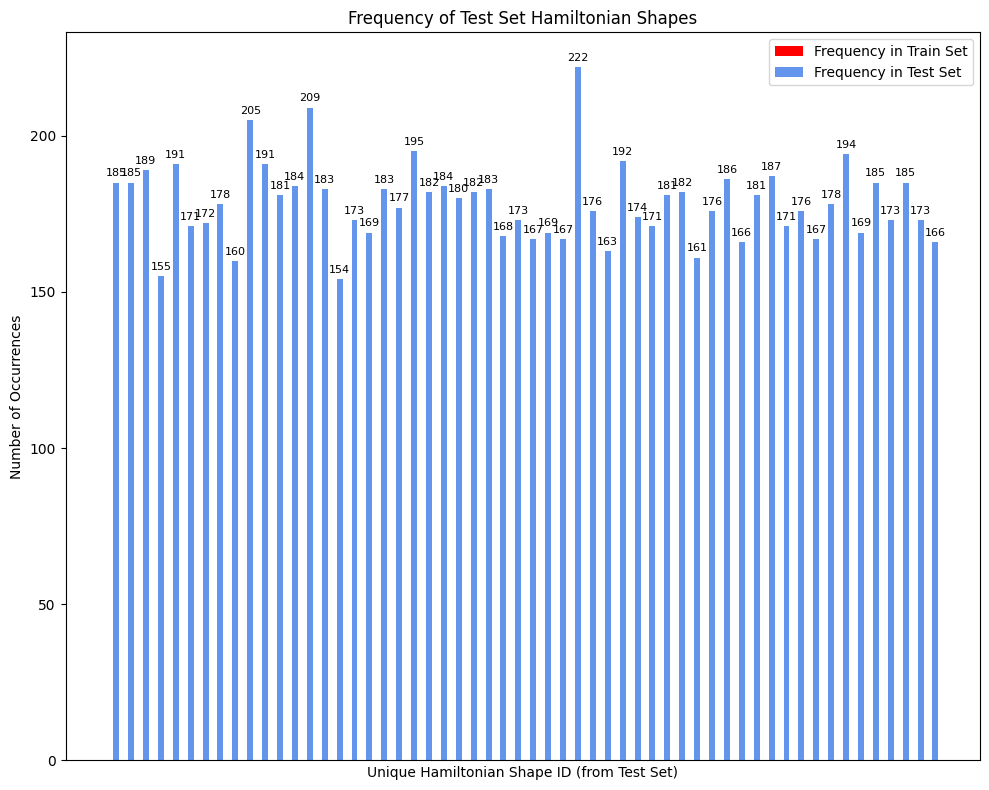

In [ ]:
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Configuration ---
# Make sure these paths point to your data files
TRAIN_FILE = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt"
TEST_FILE = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/test.txt"

from typing import Union

def extract_shape_from_line(line: str) -> Union[tuple, None]:
    """
    Parses a line from the dataset and returns the tuple of directions (the shape).
    Example: "[SOS] ab SOUTH cd ... [SEP] ..." -> ('SOUTH', 'EAST', ...)
    """
    try:
        parts = line.strip().split()
        # The Hamiltonian path is between '[SOS]' and '[SEP]'
        sep_idx = parts.index("[SEP]")
        
        # Path parts start after '[SOS]' at index 1 and go up to sep_idx
        path_parts = parts[1:sep_idx]
        
        # Directions are at the odd indices of the path parts
        directions = tuple(path_parts[1::2])
        return directions
    except (ValueError, IndexError):
        # Handle malformed lines or lines without the expected structure
        return None

def analyze_file_shapes(filepath: str) -> collections.Counter:
    """
    Reads a dataset file and returns a Counter with the frequency of each shape.
    """
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return collections.Counter()
        
    shape_counts = collections.Counter()
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Analyzing {os.path.basename(filepath)}"):
            shape = extract_shape_from_line(line)
            if shape:
                shape_counts[shape] += 1
    return shape_counts

def plot_shape_distributions(train_counts, test_counts):
    """
    Creates a histogram comparing the distribution of test set shapes
    in both the training and test sets.
    """
    # Get the unique shapes that actually appear in the test set
    test_shape_list = sorted(list(test_counts.keys()))
    
    # Get the frequency of these specific shapes in both datasets
    # For the train set, this count should be 0 if the split is correct.
    counts_in_test_set = [test_counts[shape] for shape in test_shape_list]
    counts_in_train_set = [train_counts.get(shape, 0) for shape in test_shape_list]

    # --- Plotting ---
    x = np.arange(len(test_shape_list))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 8))
    rects1 = ax.bar(x - width/2, counts_in_train_set, width, label='Frequency in Train Set', color='red')
    rects2 = ax.bar(x + width/2, counts_in_test_set, width, label='Frequency in Test Set', color='cornflowerblue')

    # Add some text for labels, title and axes ticks.
    ax.set_ylabel('Number of Occurrences')
    ax.set_title('Frequency of Test Set Hamiltonian Shapes')
    ax.set_xlabel('Unique Hamiltonian Shape ID (from Test Set)')
    ax.set_xticks([]) # Hide x-axis labels as there are too many
    ax.legend()
    ax.bar_label(rects2, padding=3, fmt='%d', fontsize=8) # Label test counts

    # Check if there are any non-zero red bars to highlight
    if any(c > 0 for c in counts_in_train_set):
        ax.text(0.5, 0.5, 'WARNING: OVERLAP DETECTED!',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes,
                fontsize=40, color='red', alpha=0.5,
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

    fig.tight_layout()
    plt.show()


if __name__ == '__main__':
    print("--- Analyzing Hamiltonian Shape Distributions ---")
    train_counts = analyze_file_shapes(TRAIN_FILE)
    test_counts = analyze_file_shapes(TEST_FILE)

    print("\n--- Analysis Results ---")
    
    train_shapes = set(train_counts.keys())
    test_shapes = set(test_counts.keys())

    print(f"Total examples analyzed in train file: {sum(train_counts.values())}")
    print(f"Total examples analyzed in test file: {sum(test_counts.values())}")
    print("-" * 20)
    print(f"Number of unique shapes found in train set: {len(train_shapes)}")
    print(f"Number of unique shapes found in test set: {len(test_shapes)}")
    
    # The most critical check:
    overlap = train_shapes.intersection(test_shapes)
    
    print("-" * 20)
    print(f"Number of overlapping shapes between train and test: {len(overlap)}")
    
    if len(overlap) == 0:
        print("\n✅ SUCCESS: The train and test sets are perfectly disjoint in terms of Hamiltonian shapes.")
        print("This confirms the holdout set was configured correctly.")
    else:
        print("\n❌ CRITICAL WARNING: Overlap detected between train and test shapes.")
        print("The holdout set is not clean. This invalidates the generalization results.")
        print("Sample of overlapping shapes:", list(overlap)[:3])
        
    # Generate the visualization
    if test_counts:
        print("\n--- Generating Visualization ---")
        plot_shape_distributions(train_counts, test_counts)
    else:
        print("\nCould not generate visualization because test set was empty or could not be read.")

--- Building Atlas from Original (seed=42) Data ---


Analyzing train.txt: 100%|██████████| 100000/100000 [00:00<00:00, 118503.99it/s]


Built atlas from 1600000 node instances.

--- Building Atlas from Unbiased (re-seeded) Data ---


Generating unbiased data: 100%|██████████| 100000/100000 [00:02<00:00, 43419.90it/s]



--- VISUALIZING THE PROOF ---


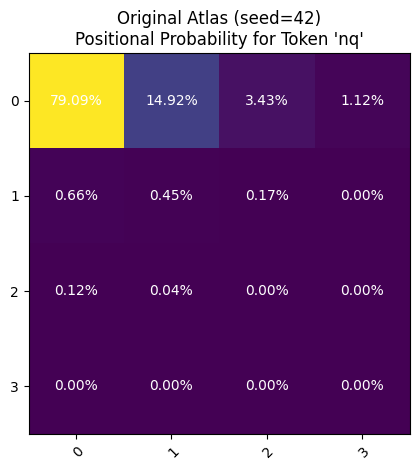

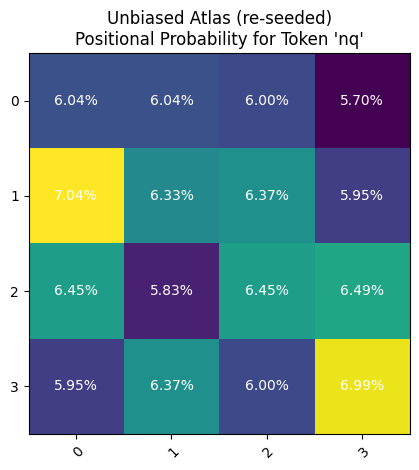

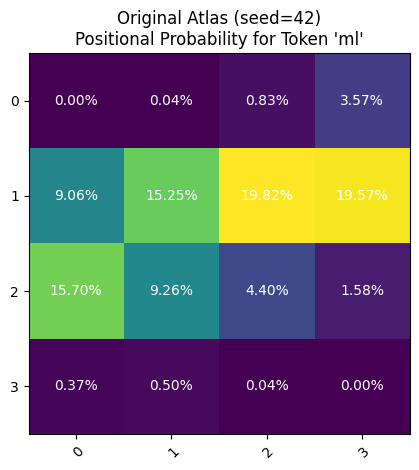

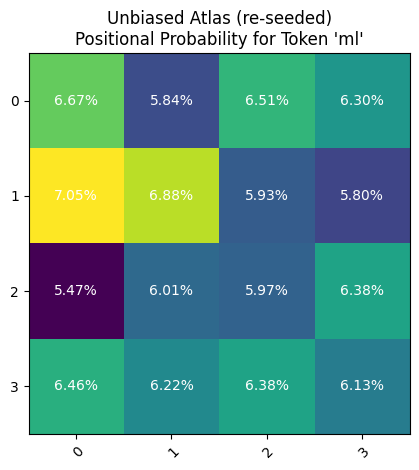

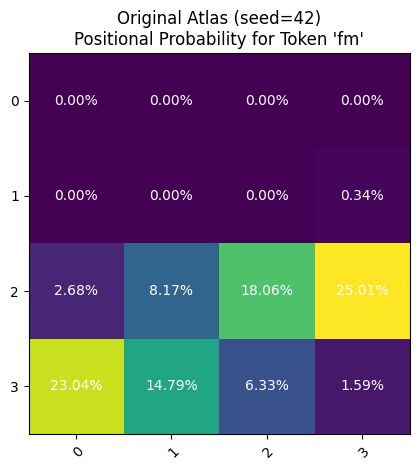

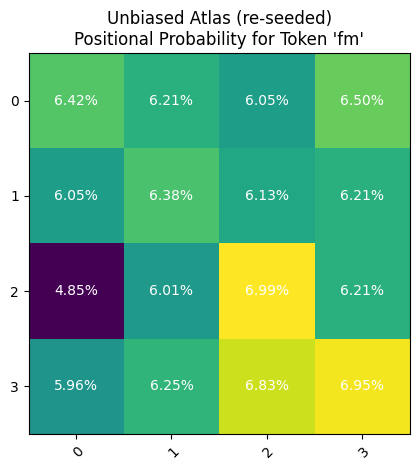

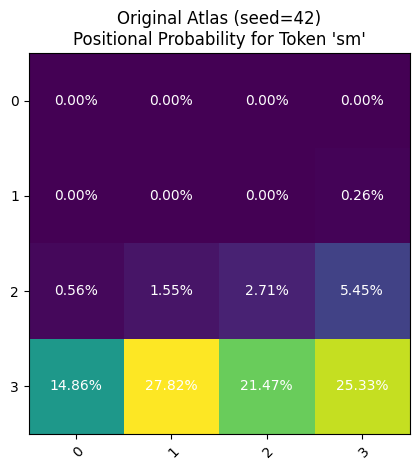

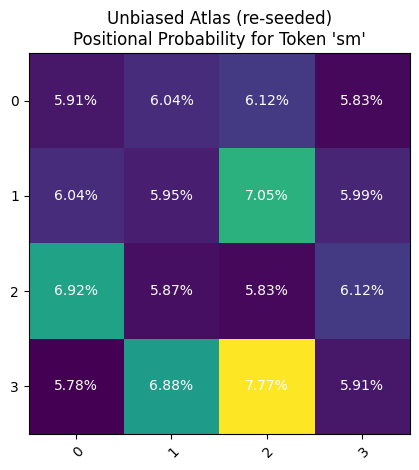

In [ ]:
# atlas_analyzer.py

import collections
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import string
import networkx as nx
import re
from typing import Dict, Tuple, Set

# --- Configuration ---
TRAIN_FILE = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/train.txt"
TEST_FILE = "/cs/student/projects1/aibh/2024/cbaumgar/MSC_THESIS/shortest_v2_data/test.txt"
NODE_RE = re.compile(r'^[a-z]{2}$')
DIR_TO_DELTA = {'NORTH': (0, -1), 'SOUTH': (0, 1), 'EAST': (1, 0), 'WEST': (-1, 0)}

# --- Helper Functions ---
def get_node_to_coord_map_from_line(line: str) -> Union[Dict[str, Tuple[int, int]], None]:
    """Parses a line and returns the mapping of each node to its absolute (x,y) coordinate."""
    try:
        parts = line.strip().split("[SEP]")[0].replace("[SOS]", "").strip().split()
        path_nodes = parts[::2]
        path_dirs = parts[1::2]
        
        node_to_coord = {path_nodes[0]: (0, 0)}
        coord = (0, 0)
        
        for i in range(len(path_dirs)):
            direction = path_dirs[i]
            dx, dy = DIR_TO_DELTA[direction]
            coord = (coord[0] + dx, coord[1] + dy)
            node_to_coord[path_nodes[i+1]] = coord
            
        # Normalize coordinates to be non-negative (e.g., grid starts at 0,0)
        min_x = min(c[0] for c in node_to_coord.values())
        min_y = min(c[1] for c in node_to_coord.values())
        normalized_map = {node: (c[0] - min_x, c[1] - min_y) for node, c in node_to_coord.items()}
        
        return normalized_map
    except (ValueError, IndexError, KeyError):
        return None

def build_atlas_from_files(files: list, limit_per_file=None):
    """Builds the frequency map P(coord | token) from a list of files."""
    atlas = collections.defaultdict(lambda: collections.Counter())
    total_nodes_processed = 0
    
    for filepath in files:
        with open(filepath, 'r') as f:
            lines = f.readlines()
        if limit_per_file:
            lines = lines[:limit_per_file]
        
        for line in tqdm(lines, desc=f"Analyzing {os.path.basename(filepath)}"):
            coord_map = get_node_to_coord_map_from_line(line)
            if coord_map:
                for node, coord in coord_map.items():
                    atlas[node][coord] += 1
                    total_nodes_processed += 1
    
    print(f"Built atlas from {total_nodes_processed} node instances.")
    return atlas

def generate_unbiased_atlas(num_examples: int):
    """Generates an atlas from on-the-fly data with non-deterministic seeding."""
    atlas = collections.defaultdict(lambda: collections.Counter())
    
    for _ in tqdm(range(num_examples), desc="Generating unbiased data"):
        random.seed() # Re-seed for each example
        # Dummy generation to get a graph
        num_nodes = 16
        names = set()
        while len(names) < num_nodes:
            names.add(''.join(random.choices(string.ascii_lowercase, k=2)))
        
        # A truly random permutation
        nodes = list(names)
        random.shuffle(nodes)

        for i, node in enumerate(nodes):
            coord = (i // 4, i % 4) # Assign to grid positions
            atlas[node][coord] += 1
            
    return atlas

def visualize_atlas_for_token(token: str, atlas: dict, title: str):
    """Creates a heatmap showing the probability distribution for a single token."""
    grid = np.zeros((4, 4))
    token_counts = atlas.get(token, collections.Counter())
    total_occurrences = sum(token_counts.values())
    
    if total_occurrences == 0:
        print(f"Token '{token}' not found in atlas.")
        return

    for coord, count in token_counts.items():
        if 0 <= coord[1] < 4 and 0 <= coord[0] < 4:
            grid[coord[1], coord[0]] = count / total_occurrences
            
    fig, ax = plt.subplots()
    im = ax.imshow(grid, cmap='viridis', interpolation='nearest')
    
    # Add text annotations
    for i in range(4):
        for j in range(4):
            ax.text(j, i, f"{grid[i, j]:.2%}", ha="center", va="center", color="w")
            
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xticklabels(np.arange(4))
    ax.set_yticklabels(np.arange(4))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(f"{title}\nPositional Probability for Token '{token}'")
    fig.tight_layout()
    plt.show()

# --- Main Execution Block ---
if __name__ == '__main__':
    print("--- Building Atlas from Original (seed=42) Data ---")
    # We analyze a subset for speed, the statistical bias will still be present.
    original_atlas = build_atlas_from_files([TRAIN_FILE], limit_per_file=100000)

    print("\n--- Building Atlas from Unbiased (re-seeded) Data ---")
    unbiased_atlas = generate_unbiased_atlas(num_examples=100000)
    
    print("\n--- VISUALIZING THE PROOF ---")
    
    # Pick a few common tokens to visualize
    common_tokens = [token for token, counts in original_atlas.items() if sum(counts.values()) > 1000][:4]
    if not common_tokens:
        print("Could not find common tokens to analyze. Please check data files.")
    
    for token in common_tokens:
        visualize_atlas_for_token(token, original_atlas, "Original Atlas (seed=42)")
        visualize_atlas_for_token(token, unbiased_atlas, "Unbiased Atlas (re-seeded)")

In [ ]:
s = {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'}
s2 = {'c', 'd', 'a', 'b', 'i', 'g', 'f', 'h', 'e'}
list1 = list(s)
list2 = list(s2)
random.shuffle(list2)  # Shuffle to ensure different order
print(list1)  # This will print the elements in the set in a specific order
print(list2)  # This will print the elements in the set in a different order

print(list1 == list2) # This will be True within the same session

['h', 'a', 'd', 'e', 'f', 'i', 'g', 'b', 'c']
['g', 'e', 'f', 'b', 'd', 'c', 'i', 'h', 'a']
False


In [ ]:
# Define two sets with same elements but created from different orderings
random.seed(42)  # Ensure deterministic order
set1 = set(['a', 'b', 'c', 'd', 'e'])
set2 = set(['e', 'd', 'c', 'b', 'a'])

print("Set1:", set1)
print("Set2:", set2)

# Check if sets are equal
print("Sets equal?", set1 == set2)

# Convert sets to lists (order depends on internal hash)
list1 = list(set1)
list2 = list(set2)

print("List1:", list1)
print("List2:", list2)

# Are the lists equal (order and content)?
print("Lists equal (order and content)?", list1 == list2)


Set1: {'a', 'd', 'e', 'b', 'c'}
Set2: {'a', 'd', 'b', 'e', 'c'}
Sets equal? True
List1: ['a', 'd', 'e', 'b', 'c']
List2: ['a', 'd', 'b', 'e', 'c']
Lists equal (order and content)? False
